# **Musical Instruments Classification**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
data_dir = '/content/drive/MyDrive/CNN_project/CNN Music'
print("Dataset path exists:", os.path.exists(data_dir))
!ls -la "{data_dir}"
!ls -la "{data_dir}/train" | head -10


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path exists: True
total 132439
drwx------ 2 root root      4096 Jan  9 05:49 '6 test samples'
-rw------- 1 root root       701 Jan  8 13:29  class_dict.csv
-rw------- 1 root root 135408352 Jan  8 13:29  EfficientNetB3-instruments-99.33.h5
-rw------- 1 root root    190984 Jan  8 13:29  instruments.csv
drwx------ 2 root root      4096 Jan  9 05:49  test
drwx------ 2 root root      4096 Jan  9 05:49  train
drwx------ 2 root root      4096 Jan  9 05:49  valid
total 120
drwx------ 2 root root 4096 Jan  9 05:49 acordian
drwx------ 2 root root 4096 Jan  9 05:49 alphorn
drwx------ 2 root root 4096 Jan  9 05:49 bagpipes
drwx------ 2 root root 4096 Jan  9 05:49 banjo
drwx------ 2 root root 4096 Jan  9 05:49 bongo drum
drwx------ 2 root root 4096 Jan  9 05:49 casaba
drwx------ 2 root root 4096 Jan  9 05:49 castanets
drwx------ 2 root root 4096 Jan  9 05:49 clari

## STEP 1: Explore Dataset Structure

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Assume standard structure: train/val/test with class subfolders
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')


In [11]:
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print("Classes:", classes[:10], "...")


Number of classes: 30
Classes: ['Didgeridoo', 'Tambourine', 'Xylophone', 'acordian', 'alphorn', 'bagpipes', 'banjo', 'bongo drum', 'casaba', 'castanets'] ...


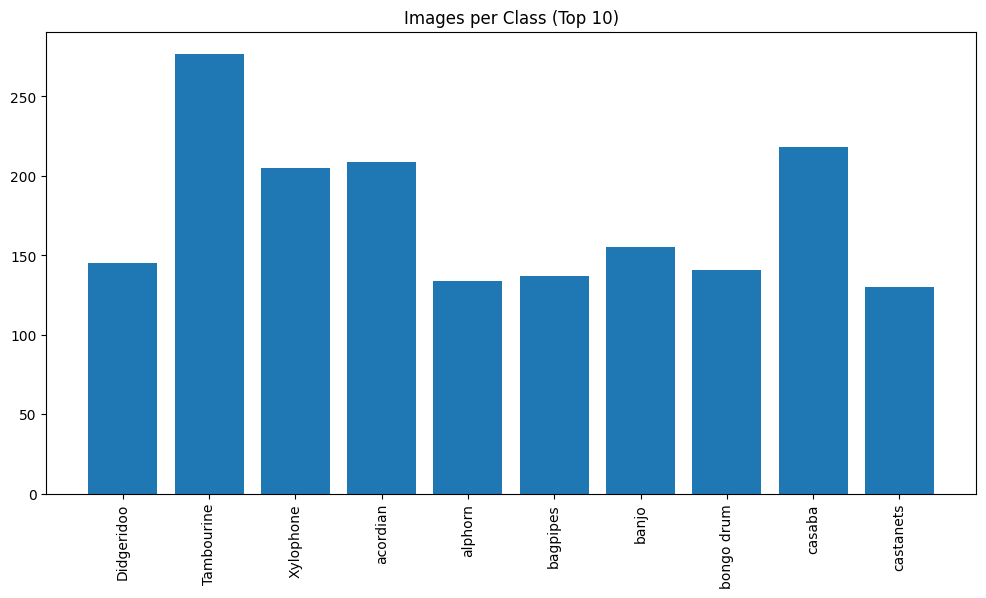

In [12]:
# Images per class
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
plt.figure(figsize=(12, 6))
plt.bar(list(train_counts.keys())[:10], list(train_counts.values())[:10])
plt.xticks(rotation=90)
plt.title("Images per Class (Top 10)")
plt.show()


In [13]:
print("Class distribution:", dict(sorted(train_counts.items(), key=lambda x: x[1])[:5]))
print("Dataset balanced? Min:", min(train_counts.values()), "Max:", max(train_counts.values()))

Class distribution: {'marakas': 114, 'guiro': 117, 'piano': 119, 'dulcimer': 126, 'ocarina': 127}
Dataset balanced? Min: 114 Max: 277


## STEP 2: Data Cleaning (Remove corrupted/duplicates)

In [14]:
import cv2
from PIL import Image
def clean_images(folder):
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img_name in images:
            try:
                img_path = os.path.join(cls_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    os.remove(img_path)
                    print(f"Removed corrupted: {img_path}")
            except:
                os.remove(img_path)
                print(f"Removed invalid: {img_path}")


In [15]:
clean_images(train_dir)
clean_images(val_dir)
clean_images(test_dir)
print("Cleaning done.")

Cleaning done.


In [16]:
!pip install tensorflow pillow scikit-learn seaborn streamlit

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print(tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 144.9 MB/s eta 0:00:00
2.19.0


## STEP 3-4: Preprocessing, Augmentation

In [18]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 4796 images belonging to 30 classes.
Found 150 images belonging to 30 classes.
Found 150 images belonging to 30 classes.


In [21]:
classes = list(train_gen.class_indices.keys())
class_indices = train_gen.class_indices
print("Data generators ready. Classes:", classes[:5], "... Total:", num_classes)

Data generators ready. Classes: ['Didgeridoo', 'Tambourine', 'Xylophone', 'acordian', 'alphorn'] ... Total: 30


## STEP 5: CNN from Scratch

In [22]:
def build_scratch_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

scratch_model = build_scratch_model()
scratch_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,411,486 (169.42 MB)

 Trainable params: 44,411,486 (169.42 MB)

 Non-trainable params: 0 (0.00 B)

## STEP 6: Transfer Learning

In [23]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,929,246 (11.17 MB)

 Trainable params: 671,262 (2.56 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## STEP 7: Training with Callbacks

In [25]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/CNN_project/best_model.h5', monitor='val_accuracy', save_best_only=True)
]

In [26]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.5546 - loss: 1.6254

149/149 ━━━━━━━━━━━━━━━━━━━━ 106s 583ms/step - accuracy: 0.5558 - loss: 1.6209 - val_accuracy: 0.9688 - val_loss: 0.0837
Epoch 2/50
  1/149 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8438 - loss: 0.5542

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8438 - loss: 0.5542 - val_accuracy: 0.9766 - val_loss: 0.0875
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 69s 464ms/step - accuracy: 0.8796 - loss: 0.3902 - val_accuracy: 0.9688 - val_loss: 0.0758
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.4728 - val_accuracy: 0.9688 - val_loss: 0.0759
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 69s 460ms/step - accuracy: 0.9051 - loss: 0.3012 - val_accuracy: 0.9766 - val_loss: 0.0777
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.4464 - val_accuracy: 0.9688 - val_loss: 0.1029
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9166 - loss: 0.2509

149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 467ms/step - accuracy: 0.9166 - loss: 0.2510 - val_accuracy: 0.9844 - val_loss: 0.0656
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9688 - loss: 0.1213 - val_accuracy: 0.9844 - val_loss: 0.0655
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 467ms/step - accuracy: 0.9298 - loss: 0.2304 - val_accuracy: 0.9766 - val_loss: 0.0651
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9688 - loss: 0.1462 - val_accuracy: 0.9844 - val_loss: 0.0571
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 69s 461ms/step - accuracy: 0.9300 - loss: 0.1991 - val_accuracy: 0.9844 - val_loss: 0.0799
Epoch 12/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.2254 - val_accuracy: 0.9688 - val_loss: 0.0872


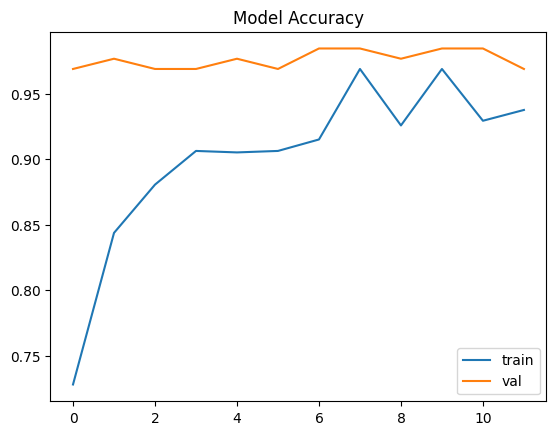

In [27]:
# Plot training
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title('Model Accuracy')
plt.show()

## STEP 8: Evaluation

In [28]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2%}")

# Predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred_classes, target_names=classes))


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9947 - loss: 0.0315
Test Accuracy: 99.33%
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
              precision    recall  f1-score   support

  Didgeridoo       1.00      1.00      1.00         5
  Tambourine       1.00      1.00      1.00         5
   Xylophone       1.00      1.00      1.00         5
    acordian       1.00      1.00      1.00         5
     alphorn       1.00      1.00      1.00         5
    bagpipes       1.00      1.00      1.00         5
       banjo       1.00      1.00      1.00         5
  bongo drum       1.00      1.00      1.00         5
      casaba       1.00      1.00      1.00         5
   castanets       1.00      1.00      1.00         5
    clarinet       1.00      1.00      1.00         5
  clavichord       1.00      1.00      1.00         5
  concertina       1.00      1.00      1.00         5
       drums       1.00      1.00      1.00         5
    dulcimer       1.00      0.80      0.89         5
     

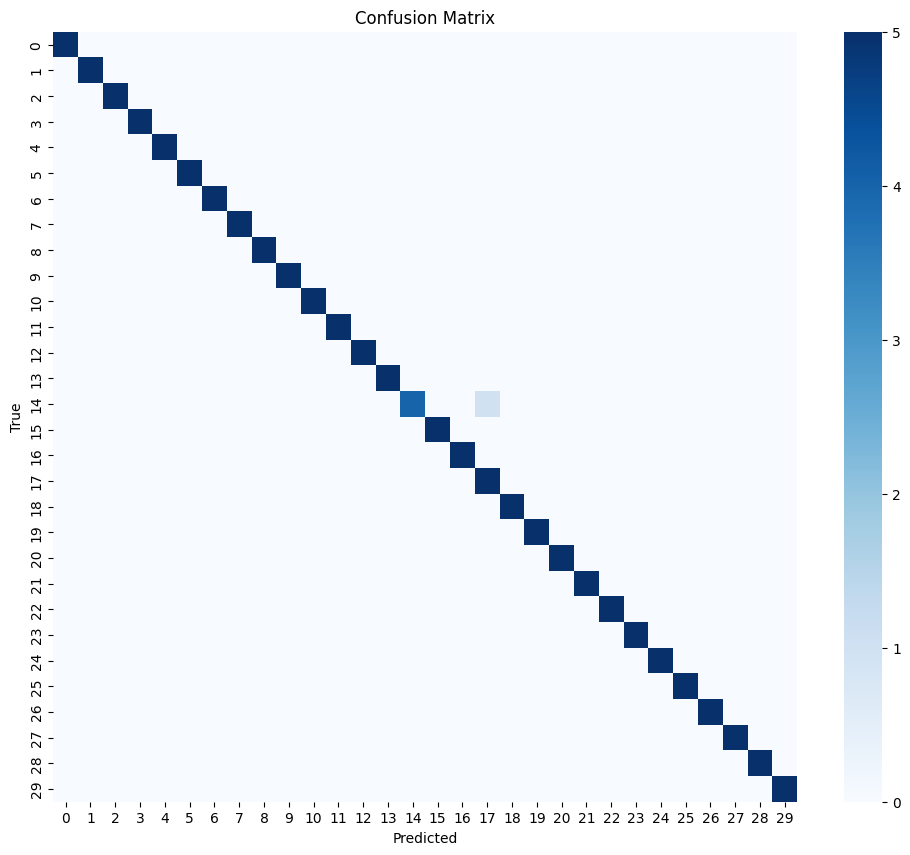

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## STEP 9: Visualize Predictions

In [30]:
sample_img, sample_label = next(test_gen)
sample_pred = model.predict(sample_img)
sample_pred_class = np.argmax(sample_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


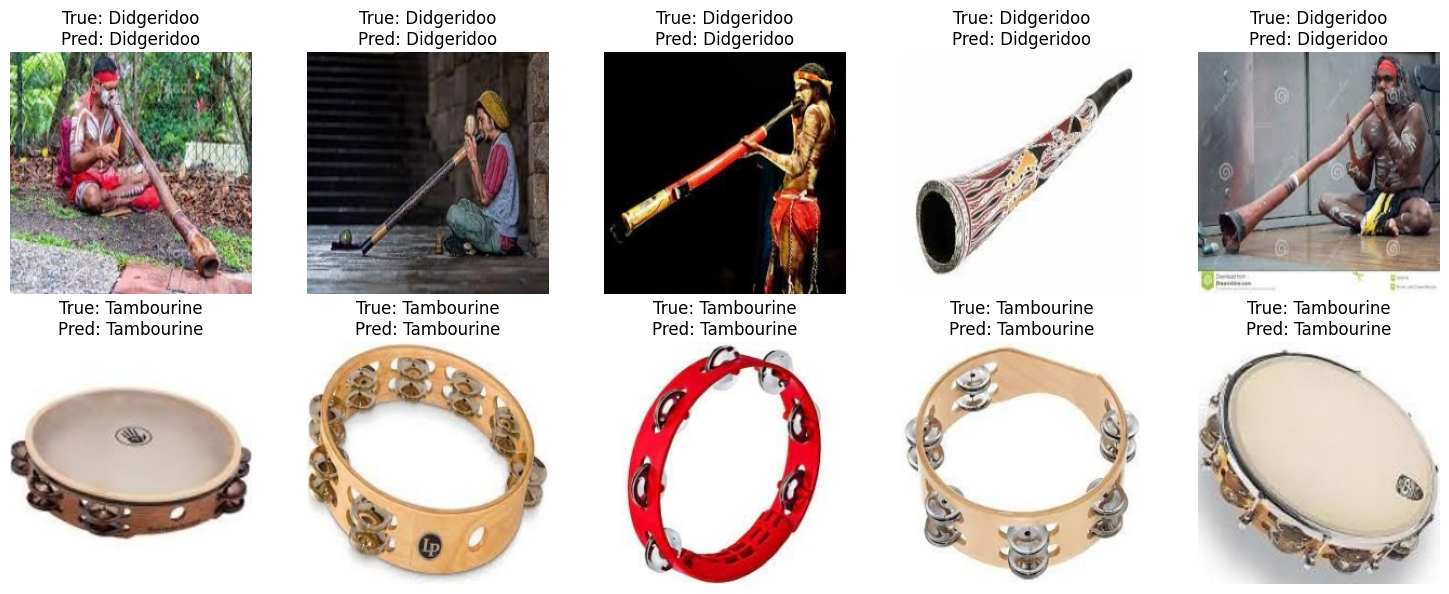

In [31]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(sample_img[i])
    true = classes[np.argmax(sample_label[i])]
    pred = classes[sample_pred_class[i]]
    ax.set_title(f"True: {true}\nPred: {pred}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## STEP 10-11: Save Model & Prediction Function + Category Mapping

In [32]:
model.save('/content/drive/MyDrive/CNN_project/final_instrument_model.h5')
np.save('/content/drive/MyDrive/CNN_project/classes.npy', classes)

In [33]:
# Category mapping (customize based on classes)
category_map = {
    'acordian': 'Western',
    'alphorn': 'Western',
    'bagpipes': 'Western',
    'banjo': 'Western',
    'bongo drum': 'Indo-Western',
    'casaba': 'Indo-Western',
    'castanets': 'Indo-Western',
    'clarinet': 'Classical',
    'clavichord': 'Classical',
    'concertina': 'Western',
    'Didgeridoo': 'Indo-Western',
    'drums': 'Western',
    'dulcimer': 'Western',
    'flute': 'Classical',
    'guiro': 'Indo-Western',
    'guitar': 'Western',
    'harmonica': 'Western',
    'harp': 'Classical',
    'marakas': 'Indo-Western',
    'ocarina': 'Western',
    'piano': 'Classical',
    'saxaphone': 'Western',
    'sitar': 'Indo-Western',
    'steel drum': 'Indo-Western',
    'Tambourine': 'Western',
    'trombone': 'Classical',
    'trumpet': 'Classical',
    'tuba': 'Classical',
    'violin': 'Classical',
    'Xylophone': 'Western'
}
category_map = {**category_map, **{cls: 'Western' for cls in classes if cls not in category_map}}

In [37]:
# Helper that works on NumPy image array from generators
def predict_instrument_from_array(img_array):
    img_array = img_array / 255.0  # if not already scaled
    if img_array.ndim == 3:
        img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    idx = np.argmax(pred[0])
    instr = classes[idx]
    cat = category_map.get(instr.lower(), 'Unknown')
    confidence = pred[0][idx]
    return instr, cat, confidence

# Test with a batch from test_gen
batch_imgs, batch_labels = next(test_gen)
print(predict_instrument_from_array(batch_imgs[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
('piano', 'Classical', np.float32(0.44217926))
